<a href="https://colab.research.google.com/github/jhonnygf/Evaluacion_metricas_clasificacion/blob/main/Evaluacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold

URL = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
RANDOM_STATE = 1

df = pd.read_csv(URL)

**Preparación de los datos**

Comprueba si los valores que faltan están presentes en las características.

Si hay valores que faltan:

*   Para características categóricas, sustitúyelas por «NA».
*   Para características numéricas, sustitúyelas por 0,0.


Divide los datos en tres partes: entrenamiento/validación/prueba con una distribución del 60 %/20 %/20 %. Utiliza la función train_test_split para ello con random_state=1.



In [31]:
categoricas = ['lead_source', 'industry', 'employment_status', 'location']
numericas = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


df[categoricas] = df[categoricas].fillna('NA')
df[numericas] = df[numericas].fillna(0)


**Pregunta 1**

El AUC ROC también se puede utilizar para evaluar la importancia de las características de las variables numéricas.


*   Para cada variable numérica, utilícela como puntuación y calcule el AUC con la variable y como verdad fundamental.
*   Utilice el conjunto de datos de entrenamiento para ello.


Si su AUC es < 0,5, invierta esta variable poniendo un «-» delante.

(e.g. -df_train['balance'])

El AUC puede ser inferior a 0,5 si la variable está correlacionada negativamente con la variable objetivo. Se puede cambiar la dirección de la correlación negando esta variable, con lo que la correlación negativa se convierte en positiva.

**¿Qué variable numérica (de las 4 siguientes) tiene el AUC más alto?**


1.   interaction_count
2.   lead_score
1.   annual_income
2.   number_of_courses_viewed



In [32]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

df.dtypes[df.dtypes != 'object'].index

Index(['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score', 'converted'],
      dtype='object')

In [33]:
for c in numericas:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])

    print('%16s, %.3f' % (c, auc))

number_of_courses_viewed, 0.764
   annual_income, 0.552
interaction_count, 0.738
      lead_score, 0.614


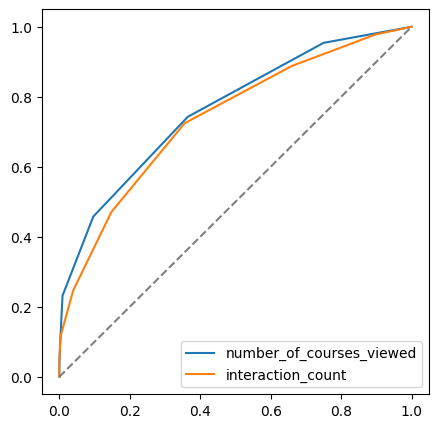

In [34]:
plt.figure(figsize=(5, 5))
fpr, tpr, _ = roc_curve(y_train, df_train.number_of_courses_viewed)
plt.plot(fpr, tpr, label='number_of_courses_viewed')

fpr, tpr, _ = roc_curve(y_train, df_train.interaction_count)
plt.plot(fpr, tpr, label='interaction_count')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.legend()
plt.show()

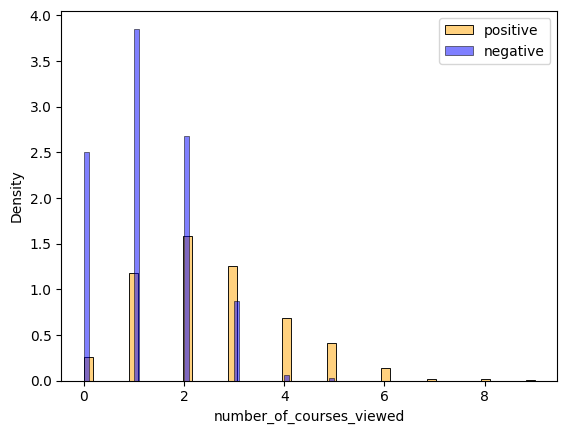

In [35]:
sns.histplot(
    df_train.number_of_courses_viewed[y_train == 1],
    stat='density',
    bins=50,
    color='orange',
    alpha=0.5,
    label='positive'
)

sns.histplot(
    df_train.number_of_courses_viewed[y_train == 0],
    stat='density',
    bins=50,
    color='blue',
    alpha=0.5,
    label='negative'
)

plt.legend()
plt.show()

**Pregunta 2**

Aplica la codificación one-hot utilizando DictVectorizer y entrena la regresión logística con estos parámetros:

LogisticRegression(solver=“liblinear”, C=1.0, max_iter=1000)

**¿Cuál es el AUC de este modelo en el conjunto de datos de validación? (redondea a 3 dígitos)**


a- 0.32

b- 0.52

c- 0.72

d- 0.92

In [36]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)
print("AUC:", round(auc, 2))

AUC: 0.82


**Pregunta 3**

Ahora calculemos la precisión y la recuperación de nuestro modelo.

Evalúe el modelo en todos los umbrales de 0,0 a 1,0 con un paso de 0,01.

Para cada umbral, calcule la precisión y la recuperación.

Trazarlos.

**¿En qué umbral se cruzan las curvas de precisión y recuperación?**

a - 0.145

b - 0.345

c - 0.545

d - 0.745


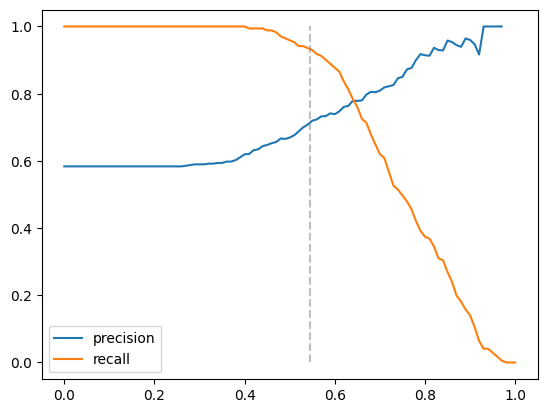

In [37]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    return df_scores


df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')
plt.vlines(0.545, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.legend()
plt.show()


In [38]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,171,122,0,0
10,0.1,171,122,0,0
20,0.2,171,122,0,0
30,0.3,171,119,0,3
40,0.4,171,105,0,17
50,0.5,164,81,7,41
60,0.6,150,53,21,69
70,0.7,106,25,65,97
80,0.8,64,6,107,116
90,0.9,24,1,147,121


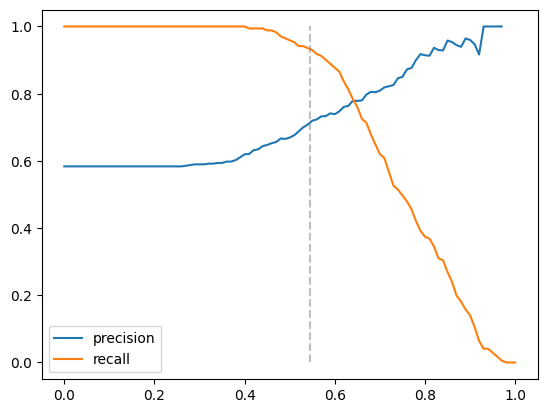

In [39]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')
plt.vlines(0.545, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

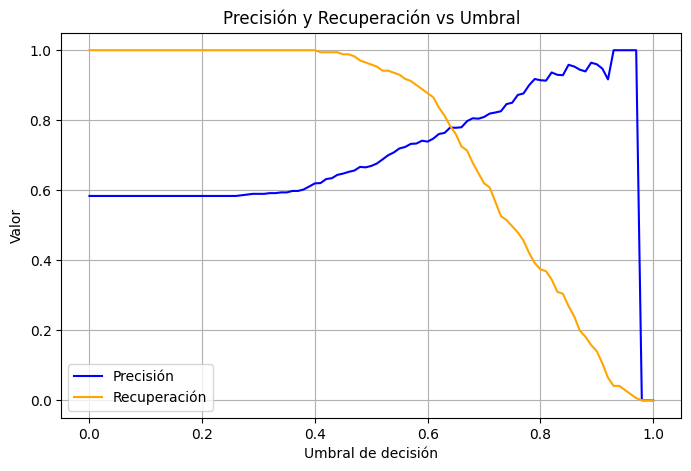

In [40]:
thresholds = np.arange(0.0, 1.01, 0.01)

precisions = []
recalls = []

for t in thresholds:
    y_pred_bin = (y_pred >= t).astype(int)

    precisions.append(precision_score(y_val, y_pred_bin, zero_division=0))

    recalls.append(recall_score(y_val, y_pred_bin, zero_division=0))

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precisión', color='blue')
plt.plot(thresholds, recalls, label='Recuperación', color='orange')
plt.xlabel('Umbral de decisión')
plt.ylabel('Valor')
plt.title('Precisión y Recuperación vs Umbral')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
prec = np.array(precisions)
rec = np.array(recalls)

mask = (prec > 0) & (rec > 0)

diff = np.abs(prec[mask] - rec[mask])

t_cruce = thresholds[mask][diff.argmin()]

print("El umbral donde se cruzan precisión y recall es:", round(t_cruce, 3))

El umbral donde se cruzan precisión y recall es: 0.64


**Pregunta 4**

La precisión y la recuperación son contradictorias: cuando una aumenta, la otra disminuye. Por eso suelen combinarse en la F1 score, una métrica que tiene en cuenta ambas.

Esta es la fórmula para calcular F1:

F1=2⋅((P⋅R)/(P+R))

Donde P  es la precisión y R  es la recuperación.

Calculemos F1 para todos los umbrales de 0,0 a 1,0 con un incremento de 0,01

**¿En qué umbral es máximo F1?**

a. 0.14

b. 0.34

c. 0.54

d. 0.74


In [42]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
den = (df_scores['p'] + df_scores['r']).replace(0, np.nan)
df_scores['f1'] = (2 * df_scores['p'] * df_scores['r'] / den).fillna(0.0)

best = df_scores.loc[df_scores.f1.idxmax()]
print(best.threshold, best.f1)


0.5700000000000001 0.8124999999999999


In [43]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

den = (df_scores['p'] + df_scores['r']).replace(0, np.nan)
df_scores['f1'] = 2 * df_scores['p'] * df_scores['r'] / den
df_scores['f1'] = df_scores['f1'].fillna(0.0)

best_row = df_scores.loc[df_scores['f1'].idxmax()]
best_row

,57
threshold,0.570000
tp,156.000000
fp,57.000000
fn,15.000000
tn,65.000000
p,0.732394
r,0.912281
f1,0.812500


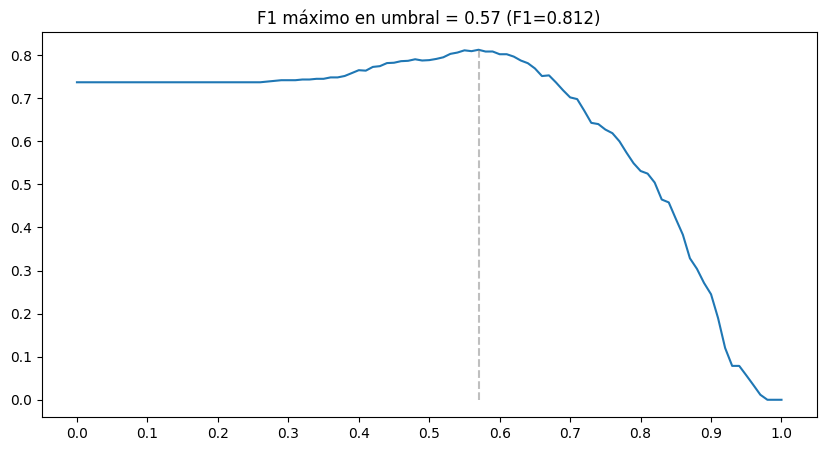

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(best_row.threshold, df_scores.f1.min(), df_scores.f1.max(),
           color='grey', linestyle='--', alpha=0.5)
plt.xticks(np.linspace(0, 1, 11))
plt.title(f"F1 máximo en umbral = {best_row.threshold:.2f} (F1={best_row.f1:.3f})")
plt.show()


In [45]:
from sklearn.metrics import f1_score

t = best_row.threshold
y_hat = (y_pred >= t).astype(int)
print("F1 sklearn @t={:.2f}: {:.6f}".format(t, f1_score(y_val, y_hat)))


F1 sklearn @t=0.57: 0.812500


**Pregunta 5**

Utiliza la clase KFold de Scikit-Learn para evaluar nuestro modelo en 5 pliegues diferentes:


KFold(n_splits=5, shuffle=True, random_state=1)

Itere sobre diferentes pliegues de df_full_train

Divida los datos en entrenamiento y validación

Entrene el modelo en entrenamiento con estos parámetros: LogisticRegression(solver=“liblinear”, C=1.0, max_iter=1000)

Utilice AUC para evaluar el modelo en validación

**¿Cuál es la desviación estándar de las puntuaciones en los diferentes folds?**



a. 0.0001

b. 0.36

c. 0.006

d. 0.06




In [46]:
df_full = df_full_train.copy().reset_index(drop=True)
y_full = df_full.converted.values
X_full = df_full.drop(columns=['converted'])

kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kf.split(X_full):
    X_tr = X_full.iloc[train_idx]
    X_va = X_full.iloc[val_idx]
    y_tr = y_full[train_idx]
    y_va = y_full[val_idx]

    train_dicts = X_tr.to_dict(orient='records')
    val_dicts   = X_va.to_dict(orient='records')

    dv = DictVectorizer()
    X_tr_enc = dv.fit_transform(train_dicts)
    X_va_enc = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_tr_enc, y_tr)

    y_va_pred = model.predict_proba(X_va_enc)[:, 1]
    auc = roc_auc_score(y_va, y_va_pred)
    scores.append(auc)

print("AUC por fold:", [round(s, 3) for s in scores])
print("Media AUC:", round(np.mean(scores), 3))
print("Desviación estándar:", round(np.std(scores), 3))

AUC por fold: [np.float64(0.806), np.float64(0.871), np.float64(0.775), np.float64(0.802), np.float64(0.856)]
Media AUC: 0.822
Desviación estándar: 0.036


**Pregunta 6**

Ahora utilicemos la validación cruzada de 5 folds para encontrar el mejor parámetro C.


Iteremos sobre los siguientes valores de C: [0,000001; 0,001; 1].

Inicializar KFold con los mismos parámetros que anteriormente

Utilizar estos parámetros para el modelo: LogisticRegression(solver=“liblinear”, C=C, max_iter=1000)

Calcular la puntuación media y la desviación estándar (redondear mean y std a 3 decimales)

**¿Qué C da lugar a la mejor puntuación media?**

a. 0.000001

b. 0.001

c. 1


In [47]:
C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

df_full = df_full_train.copy().reset_index(drop=True)
y_full = df_full.converted.values
X_full = df_full.drop(columns=['converted'])

for C in C_values:
    scores = []
    for train_idx, val_idx in kf.split(X_full):
        X_tr = X_full.iloc[train_idx]
        X_va = X_full.iloc[val_idx]
        y_tr = y_full[train_idx]
        y_va = y_full[val_idx]

        # one-hot por fold
        train_dicts = X_tr.to_dict(orient='records')
        val_dicts = X_va.to_dict(orient='records')

        dv = DictVectorizer()
        X_tr_enc = dv.fit_transform(train_dicts)
        X_va_enc = dv.transform(val_dicts)

        # modelo
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_tr_enc, y_tr)

        # AUC
        y_va_pred = model.predict_proba(X_va_enc)[:, 1]
        auc = roc_auc_score(y_va, y_va_pred)
        scores.append(auc)

    print(f"C={C}")
    print("AUCs:", [round(s, 3) for s in scores])
    print("Mean: %.3f, Std: %.3f" % (np.mean(scores), np.std(scores)))
    print()

C=1e-06
AUCs: [np.float64(0.557), np.float64(0.519), np.float64(0.589), np.float64(0.558), np.float64(0.577)]
Mean: 0.560, Std: 0.024

C=0.001
AUCs: [np.float64(0.861), np.float64(0.897), np.float64(0.823), np.float64(0.854), np.float64(0.9)]
Mean: 0.867, Std: 0.029

C=1
AUCs: [np.float64(0.806), np.float64(0.871), np.float64(0.775), np.float64(0.802), np.float64(0.856)]
Mean: 0.822, Std: 0.036

